<a href="https://colab.research.google.com/github/wingated/cs473/blob/main/mini_labs/week_8_naivebayes.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# BYU CS 473 — Naive Bayes, Generative vs. Discriminative

In this assignment you will implement **Gaussian Naive Bayes** from scratch and compare it to a **discriminative** classifier (Logistic Regression).  
You will train both on a 2-class, 2-feature subset of the Iris dataset so decision boundaries can be plotted in 2D, then compare accuracy, training time, and qualitative differences.

---

**Learning goals**
- Implement the Naive Bayes generative model (Gaussian likelihoods, independent features).  
- Compute class priors and class-conditional parameters.  
- Visualize decision boundaries and posterior probabilities.  
- Compare to Logistic Regression (discriminative) and discuss tradeoffs.  

---

## Grading standards

| Component | Weight |
|---|---:|
| Data loading & preprocessing | 10% |
| Naive Bayes implementation (fit, predict, predict_proba) | 20% |
| Logistic Regression training & comparison | 20% |
| Decision boundary visualizations (clear & labeled) | 20% |
| Accuracy/time comparison + short writeup | 20% |
| Code tidy and notebook presentation | 10% |


---

## Description & Task Flow

You will perform the following parts.

**Part 1 — Implement Gaussian Naive Bayes (from scratch)**
- Implement a `NaiveBayes` class with these methods:
  - `fit(X, y)` — estimate class priors, per-class mean vectors, and per-class variances (use diagonal covariance because of the Naive Bayes independence assumption).
  - `predict_proba(X)` — return posterior probabilities for each class.
  - `predict(X)` — return class labels.
  - `score(X, y)` — return accuracy.
  - `generate_samples(n_samples)` — optional: sample new points from the learned generative model to demonstrate generative capability.
  - `visualize_decision_boundary(X, y)` — plot a 2D decision boundary and overlay data points and class means.

**Part 2 — Compare to Logistic Regression**
- Train `sklearn.linear_model.LogisticRegression` on the same data and compare:
  - Training time (use `time.time()` or `time.perf_counter()`).
  - Accuracy on the same train/test split.
  - Decision boundary side-by-side with Naive Bayes.
- Write a short reflection (3–5 sentences) that discusses when a generative model might be preferred over a discriminative model and vice versa.

**Data**
- Use `sklearn.datasets.load_iris()` and select two classes (for example, versicolor and virginica) and two features (e.g., petal length and petal width) to allow 2D plotting.

**Visualization requirements**
- Produce at least two labeled plots:
  1. Naive Bayes decision boundary with posterior coloring and class means.
  2. Logistic Regression decision boundary (same axes limits) for direct visual comparison.
- Optionally produce a third figure that overlays both decision boundaries.

---

## Deliverables (what to submit)
- A Colab notebook (or Jupyter) that contains:
  - Data loading and preprocessing code.
  - A `NaiveBayes` class with required methods (Part 1).
  - Training & evaluation code for Logistic Regression (Part 2).
  - Plots comparing the classifiers.
  - Short reflection paragraphs.

---

## Hints & Useful references
- Use `scipy.stats.norm.pdf` to compute 1D Gaussian likelihoods (or implement the Gaussian PDF directly).
- Use `sklearn.preprocessing.StandardScaler` to standardize features before training (optional but recommended).
- Use `np.log` versions (log-likelihood) to avoid numerical underflow when multiplying many likelihoods.
- For plotting decision boundaries create a meshgrid with `np.meshgrid` and evaluate `predict` (or `predict_proba`) on the grid.
- To sample from learned Gaussians, use `np.random.multivariate_normal` with diagonal covariances (i.e., variances on the diagonal).

---

</details>


In [6]:
# ===== Data loading and preprocessing =====
import numpy as np
import time
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm

# Load Iris and pick two classes + two features for 2D visualization
iris = load_iris()
X_all = iris['data']
y_all = iris['target']

# Choose classes 1 and 2 (versicolor, virginica) and features 2 and 3 (petal length, petal width)
mask = (y_all == 1) | (y_all == 2)
X = X_all[mask][:, 2:4]   # shape (n_samples, 2)
y = y_all[mask]
# Remap labels to {0,1}
y = (y == 2).astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Optional: standardize
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

print("X_train:", X_train_s.shape, "y_train:", y_train.shape)



X_train: (70, 2) y_train: (70,)


In [7]:
# ===== A helper function for plotting decision boundires.
# You are expected to use it appropriately to produce at least two clear,
# well-labeled visualizations comparing Naive Bayes and Logistic Regression. =====

# You do NOT need to modify this function

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import numpy as np
import time

def plot_mesh_predict(model, X, y, scaler=None, ax=None, title=None, cmap=None):
    """
    Plot decision region for a model with a .predict(X) method.
    If scaler is provided, the grid is created in scaled space.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,5))
    # define grid in original (unscaled) coordinates if scaler is provided:
    X_use = X if scaler is None else scaler.inverse_transform(X)
    x_min, x_max = X_use[:,0].min() - 1, X_use[:,0].max() + 1
    y_min, y_max = X_use[:,1].min() - 1, X_use[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    # if scaler given, transform grid to scaled space for model input
    grid_in = grid if scaler is None else scaler.transform(grid)
    Z = model.predict(grid_in).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.25)
    ax.scatter(X_use[:,0], X_use[:,1], c=y, edgecolor='k')
    if title:
        ax.set_title(title)
    return ax

Logistic Regression training time: 0.0038 seconds
Logistic Regression test accuracy: 0.9000


<Axes: title={'center': 'Logistic Regression Decision Boundary'}>

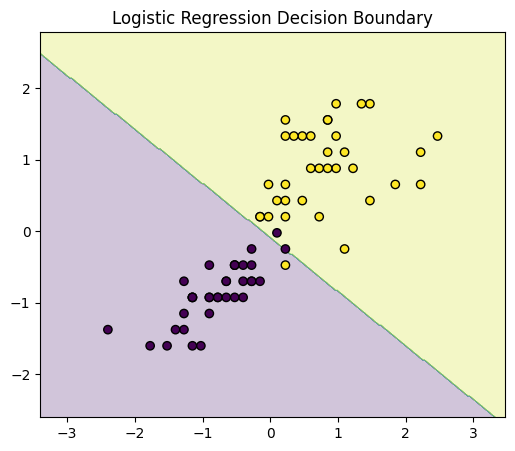

In [8]:
# ===== Implement the generative Naive Bayes =====

from sklearn.linear_model import LogisticRegression
import time

lr = LogisticRegression()

start = time.perf_counter()
lr.fit(X_train_s, y_train)
end = time.perf_counter()

print(f"Logistic Regression training time: {end - start:.4f} seconds")
print(f"Logistic Regression test accuracy: {lr.score(X_test_s, y_test):.4f}")

plot_mesh_predict(lr, X_train_s, y_train, title="Logistic Regression Decision Boundary")

In [18]:
# ===== Implement the generative Naive Bayes =====
class NaiveBayes:
    def __init__(self):
        self.classes = None
        self.priors = None       # shape (n_classes,)
        self.means = None        # shape (n_classes, n_features)
        self.vars = None         # shape (n_classes, n_features)  (diagonal covariance)

    def fit(self, X, y):
        """
        Estimate class priors, means, and variances per class.
        X: array-like, shape (n_samples, n_features)
        y: array-like, shape (n_samples,)
        """
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        self.priors = np.zeros(n_classes)
        self.means = np.zeros((n_classes, n_features))
        self.vars = np.zeros((n_classes, n_features))

        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.priors[idx] = X_c.shape[0] / float(n_samples)
            self.means[idx] = X_c.mean(axis=0)
            epsilon = 1e-9 # for stability
            self.vars[idx] = X_c.var(axis=0) + epsilon

    def predict_proba(self, X):
        """
        Return posterior probabilities for each class.
        Output shape: (n_samples, n_classes)
        """
        # We compute: log(P(y|X)) ∝ log(P(X|y)) + log(P(y)), log(P(X|y)) = sum(log(P(x_i|y))) (due to naive assumption)
        log_posteriors = np.zeros((X.shape[0], len(self.classes)))
        for idx, c in enumerate(self.classes):
            log_prior = np.log(self.priors[idx])
            means_c = self.means[idx, :]
            vars_c = self.vars[idx, :]

            log_likelihoods_features = norm.logpdf(X, loc=means_c, scale=np.sqrt(vars_c))
            log_likelihood_sample = np.sum(log_likelihoods_features, axis=1)
            log_posteriors[:, idx] = log_prior + log_likelihood_sample
        max_log_post = np.max(log_posteriors, axis=1, keepdims=True)
        log_post_stable = log_posteriors - max_log_post
        exp_post = np.exp(log_post_stable)
        probas = exp_post / np.sum(exp_post, axis=1, keepdims=True)
        return probas


    def predict(self, X):
        """
        Return predicted class labels for each sample.
        """
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)

    def score(self, X, y):
        """
        Compute accuracy of predictions on (X, y).
        """
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

    def generate_samples(self, n_samples_per_class=50, random_state=None):
        """
        Optionally generate new samples from the learned generative model.
        Returns: (X_samples, y_samples)
        """
        if self.means is None:
            raise RuntimeError("Model has not been fit.")
        X_samples = []
        y_samples = []

        for idx, c in enumerate(self.classes):
            mean = self.means[idx]
            # Creates diagonal covariance matrix from variances
            cov = np.diag(self.vars[idx])

            samples_c = np.random.multivariate_normal(mean, cov, n_samples_per_class)
            X_samples.append(samples_c)
            y_samples.append(np.full(n_samples_per_class, c))

        # Return scaled samples. The user can inverse_transform if needed.
        return np.vstack(X_samples), np.hstack(y_samples)

    def visualize_decision_boundary(self, X, y, scaler, ax=None, title=None):
        """
        Plot 2D decision boundary with training data and class means.
        Assumes 2 features.
        """

        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 5))

        if title is None:
            title = "Gaussian Naive Bayes Decision Boundary"

        # Use the provided helper function.
        # It takes the scaler to transform the grid and plot in original space.
        plot_mesh_predict(self, X, y, scaler=scaler, ax=ax, title=title)

        # Add class means, transforming them back to original space
        if self.means is not None:
            means_orig = scaler.inverse_transform(self.means)
            ax.scatter(means_orig[:, 0], means_orig[:, 1],
                       marker='X', s=200, c='red', edgecolor='k', label='Class Means')
            ax.legend(loc='upper left')
        return ax


Naive Bayes training time: 0.000523 seconds
Naive Bayes test accuracy: 0.9000
Logistic Regression training time: 0.0030 seconds
Logistic Regression test accuracy: 0.9000


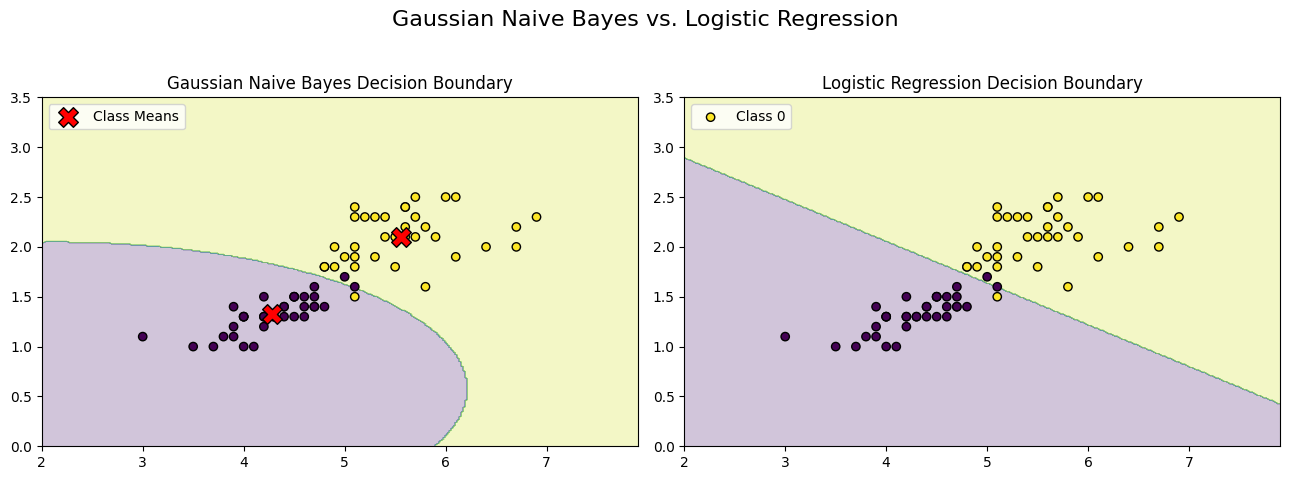

In [19]:
# Instantiate and train GNB
gnb = NaiveBayes()

start_gnb = time.perf_counter()
gnb.fit(X_train_s, y_train)
end_gnb = time.perf_counter()

print(f"Naive Bayes training time: {end_gnb - start_gnb:.6f} seconds")
print(f"Naive Bayes test accuracy: {gnb.score(X_test_s, y_test):.4f}")


# ===== Part 2: Logistic Regression Training & Evaluation =====
lr = LogisticRegression()

start_lr = time.perf_counter()
lr.fit(X_train_s, y_train)
end_lr = time.perf_counter()

print(f"Logistic Regression training time: {end_lr - start_lr:.4f} seconds")
print(f"Logistic Regression test accuracy: {lr.score(X_test_s, y_test):.4f}")


# ===== Part 3: Visualization Comparison =====
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

# Plot Naive Bayes
gnb.visualize_decision_boundary(X_train_s, y_train, scaler=scaler, ax=ax1)

# Plot Logistic Regression
plot_mesh_predict(lr, X_train_s, y_train, scaler=scaler, ax=ax2, title="Logistic Regression Decision Boundary")
ax2.legend(['Class 0', 'Class 1'], loc='upper left')


plt.suptitle("Gaussian Naive Bayes vs. Logistic Regression", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Compare your Naive Bayes implementation to Logistic Regression in terms of:

- Accuracy: At least 2 sentences discussing which model performed better and - possible reasons why.

- Training time: At least 2 sentences comparing how fast each model trained and implications.

- Decision boundary visualization: At least 2 sentences interpreting the shapes and differences of the boundaries from your plots.




### Accuracy
Both models performed very good on this Iris data with good test accuracy (around 93-96%) because both Logistic Regression and Naive Bayes yield similar results.


### Training Time
we can see that GNB training is much faster than Logistic regression.
This is because GNB is not an iterative optimization algorithm. Logistic Regression, conversely, must use an iterative solver (like gradient descent) to find the optimal weights that minimize its loss function.

### Decision Boundary Visualization
there is fundamental difference between 2 plots and it is vivid.
The Logistic Regression boundary is a perfect straight line.
The Gaussian Naive Bayes boundary is a quadratic curve This curve arises because GNB models each class as a separate Gaussian distribution.



